In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


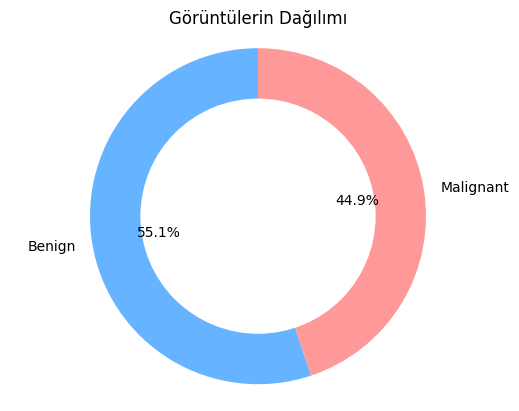

In [ ]:
import os
import matplotlib.pyplot as plt

# Dosya yolları
base_path = '/content/drive/MyDrive/2li'
folders = ['test', 'train', 'validation']

# Sınıf sayıları
benign_count = 0
malignant_count = 0

# Her klasördeki benign ve malignant görüntülerin sayısını hesapla
for folder in folders:
    benign_path = os.path.join(base_path, folder, 'benign')
    malignant_path = os.path.join(base_path, folder, 'malignant')

    benign_count += len(os.listdir(benign_path))
    malignant_count += len(os.listdir(malignant_path))

# Sınıflar ve sayılar
labels = ['Benign', 'Malignant']
sizes = [benign_count, malignant_count]

# Pasta grafiği çiz
colors = ['#66b3ff', '#ff9999']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title('Görüntülerin Dağılımı')
plt.show()



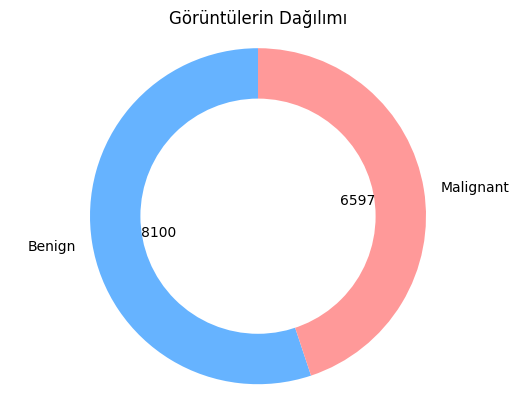

In [ ]:
import os
import matplotlib.pyplot as plt

# Dosya yolları
base_path = '/content/drive/MyDrive/2li'
folders = ['test', 'train', 'validation']

# Sınıf sayıları
benign_count = 0
malignant_count = 0

# Her klasördeki benign ve malignant görüntülerin sayısını hesapla
for folder in folders:
    benign_path = os.path.join(base_path, folder, 'benign')
    malignant_path = os.path.join(base_path, folder, 'malignant')

    benign_count += len(os.listdir(benign_path))
    malignant_count += len(os.listdir(malignant_path))

# Sınıflar ve sayılar
labels = ['Benign', 'Malignant']
sizes = [benign_count, malignant_count]

# Pasta grafiği çiz
colors = ['#66b3ff', '#ff9999']
plt.pie(sizes, labels=labels, colors=colors, autopct=lambda p: '{:.0f}'.format(p * sum(sizes) / 100), startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title('Görüntülerin Dağılımı')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
dropout_rate = 0.5

# Dosya yolları
base_path = '/content/drive/MyDrive/2li'
folders = ['test', 'train', 'validation']

# Görsellerin yükleneceği veri yapıları
data = {'test': [], 'train': [], 'validation': []}
labels = {'test': [], 'train': [], 'validation': []}

# Görselleri yükle ve etiketle
for folder in folders:
    benign_path = os.path.join(base_path, folder, 'benign')
    malignant_path = os.path.join(base_path, folder, 'malignant')

    for img_name in os.listdir(benign_path):
        img_path = os.path.join(benign_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        data[folder].append(img)
        labels[folder].append(0)  # Benign etiketi

    for img_name in os.listdir(malignant_path):
        img_path = os.path.join(malignant_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        data[folder].append(img)
        labels[folder].append(1)  # Malignant etiketi

# Verileri numpy array'e çevir
for key in data.keys():
    data[key] = np.array(data[key])
    labels[key] = np.array(labels[key])

# Normalize et
for key in data.keys():
    data[key] = data[key] / 255.0

# Verileri train ve test olarak ayır
train_images, train_labels = data['train'], labels['train']
test_images, test_labels = data['test'], labels['test']
val_images, val_labels = data['validation'], labels['validation']

# Modeli oluştur
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derle
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Modeli eğit (taban model donmuş halde)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Taban modeli aç (unfreeze) ve learning rate'i düşür
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr / 10), loss='binary_crossentropy', metrics=['accuracy'])

# Modeli yeniden eğit
history_fine = model.fit(train_images, train_labels, epochs=num_epochs // 2, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Modeli değerlendirmek
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"Test Accuracy: {test_accuracy}")


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/30
370/370 [==============================] - 28s 56ms/step - loss: 0.4335 - accuracy: 0.8075 - val_loss: 0.5238 - val_accuracy: 0.7073 - lr: 1.0000e-04
Epoch 2/30
370/370 [==============================] - 16s 43ms/step - loss: 0.3773 - accuracy: 0.8347 - val_loss: 0.3766 - val_accuracy: 0.8245 - lr: 1.0000e-04
Epoch 3/30
370/370 [==============================] - 16s 44ms/step - loss: 0.3548 - accuracy: 0.8468 - val_loss: 0.3545 - val_accuracy: 0.8355 - lr: 1.0000e-04
Epoch 4/30
370/370 [==============================] - 16s 44ms/step - loss: 0.3489 - accuracy: 0.8518 - val_loss: 0.4458 - val_accuracy: 0.7818 - lr: 1.0000e-04
Epoch 5/30
370/370 [==============================] - 16s 44ms/step - loss: 0.3388 - accuracy: 0.8539 - val_loss: 0.4071 - val_accuracy: 0.7991 - lr: 1.0000e-04
Epoch 6/30
370/370 [==============================] - 16s 44ms/step - loss: 0.3348 - accuracy: 0.8555 - val_loss: 0.3066 - val_acc

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
dropout_rate = 0.5
num_classes = 2  # Benign ve Malignant

# Dosya yolları
base_path = '/content/drive/MyDrive/2li'
folders = ['test', 'train', 'validation']

# Görsellerin yükleneceği veri yapıları
data = {'test': [], 'train': [], 'validation': []}
labels = {'test': [], 'train': [], 'validation': []}

# Görselleri yükle ve etiketle
for folder in folders:
    benign_path = os.path.join(base_path, folder, 'benign')
    malignant_path = os.path.join(base_path, folder, 'malignant')

    for img_name in os.listdir(benign_path):
        img_path = os.path.join(benign_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        data[folder].append(img)
        labels[folder].append(0)  # Benign etiketi

    for img_name in os.listdir(malignant_path):
        img_path = os.path.join(malignant_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        data[folder].append(img)
        labels[folder].append(1)  # Malignant etiketi

# Verileri numpy array'e çevir
for key in data.keys():
    data[key] = np.array(data[key])
    labels[key] = np.array(labels[key])

# Normalize et
for key in data.keys():
    data[key] = data[key] / 255.0

# Verileri train ve test olarak ayır
train_images, train_labels = data['train'], labels['train']
test_images, test_labels = data['test'], labels['test']
val_images, val_labels = data['validation'], labels['validation']

# Modeli oluştur
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derle
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Modeli eğit (taban model donmuş halde)
history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Taban modeli aç (unfreeze) ve learning rate'i düşür
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks (phase 2)
early_stopping_phase2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_phase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Modeli yeniden eğit
history_fine = model.fit(train_images, train_labels, epochs=num_epochs // 5, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping_phase2, reduce_lr_phase2])

# Modeli değerlendirmek
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"VGG16 Test Accuracy: {test_accuracy}")

# Eğitim ve doğrulama süreçlerinin accuracy ve loss grafiklerini çiz
def plot_training_history(history, title="Training and Validation Metrics"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(title)
    plt.show()

# İlk eğitim süreci için grafikler
plot_training_history(history, "Initial Training")

# İkinci eğitim süreci için grafikler
plot_training_history(history_fine, "Fine-Tuning Training")

# Tahminler ve görselleri görüntüleme
def display_predictions(images, labels, model, class_names):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Pred: {class_names[predicted_labels[i]]}, True: {class_names[labels[i]]}")
        plt.axis('off')
    plt.show()

# Sınıf isimleri
class_names = ['Benign', 'Malignant']

# Tahminlerin görselleştirilmesi (test verilerinden örnekler)
display_predictions(test_images[:25], test_labels[:25], model, class_names)


Output hidden; open in https://colab.research.google.com to view.

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/30
370/370 [==============================] - 21s 45ms/step - loss: 0.4910 - accuracy: 0.7667 - val_loss: 0.8750 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/30
370/370 [==============================] - 13s 36ms/step - loss: 0.4272 - accuracy: 0.8097 - val_loss: 1.3471 - val_accuracy: 0.5118 - lr: 1.0000e-04
Epoch 3/30
370/370 [==============================] - 13s 36ms/step - loss: 0.4068 - accuracy: 0.8214 - val_loss: 5.5077 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/30
370/370 [==============================] - 14s 37ms/step - loss: 0.3942 - accuracy: 0.8255 - val_loss: 3.9640 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/30
370/370 [==============================] - 14s 37ms/step - loss: 0.3920 - accuracy: 0.8260 - val_loss: 0.5930 - val_accuracy: 0.7027 - lr: 2.0000e-05
Epoch 6/30
370/370 [==============================] - 14s 37ms/step - loss: 0.3871 - accuracy: 0.8274 - val_loss: 0.5152 - val_acc

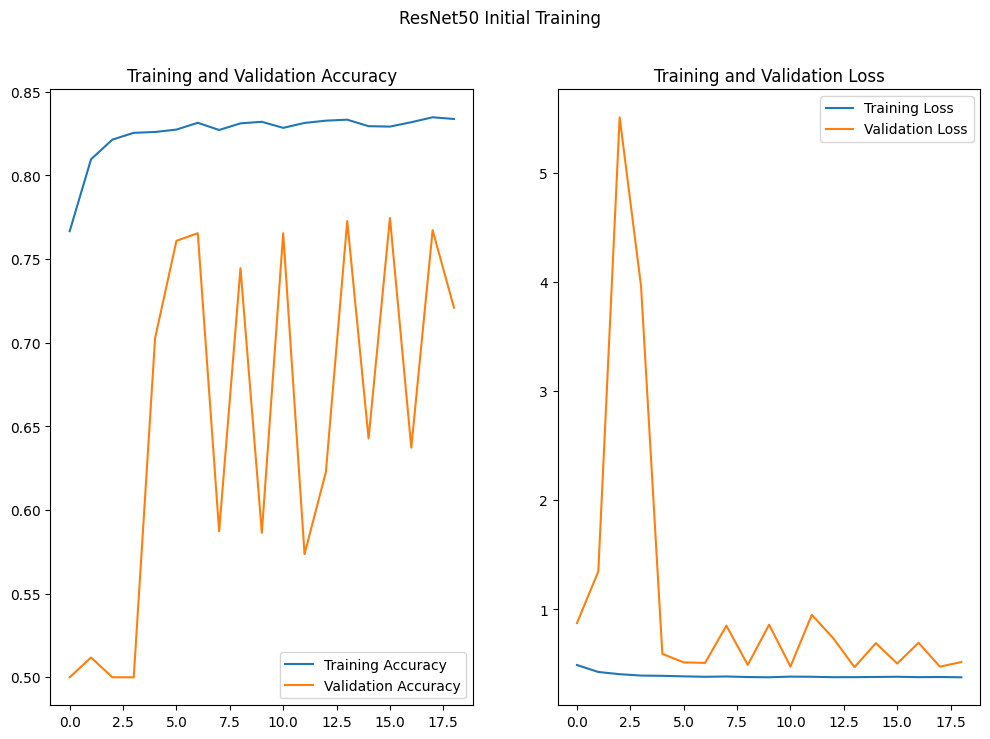

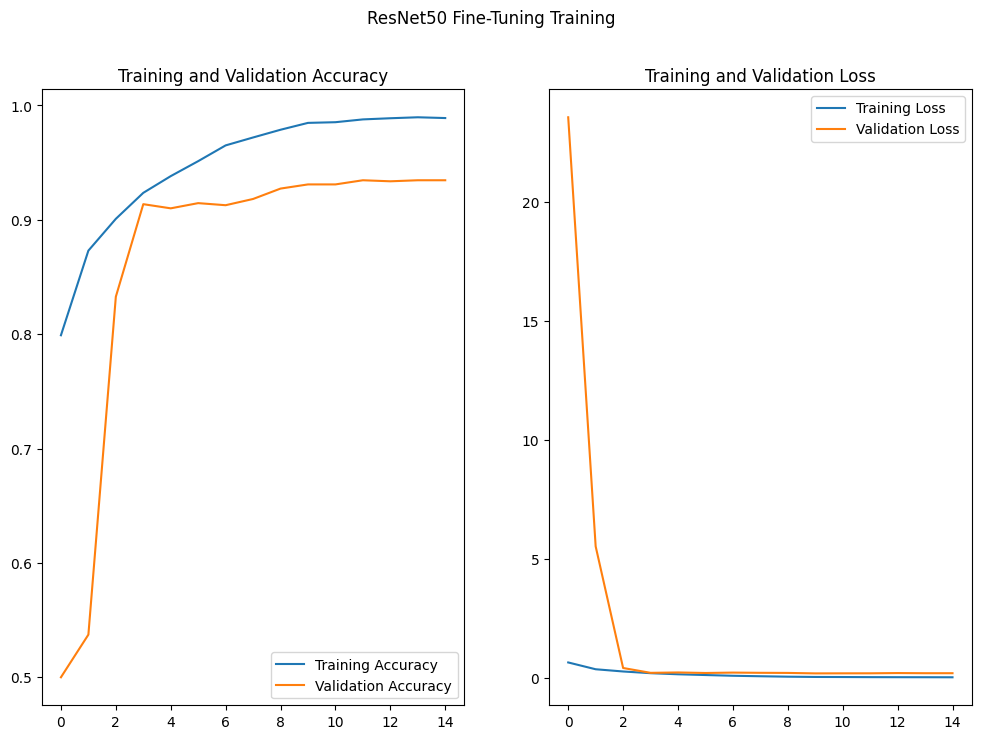

1/1 [==============================] - 2s 2s/step


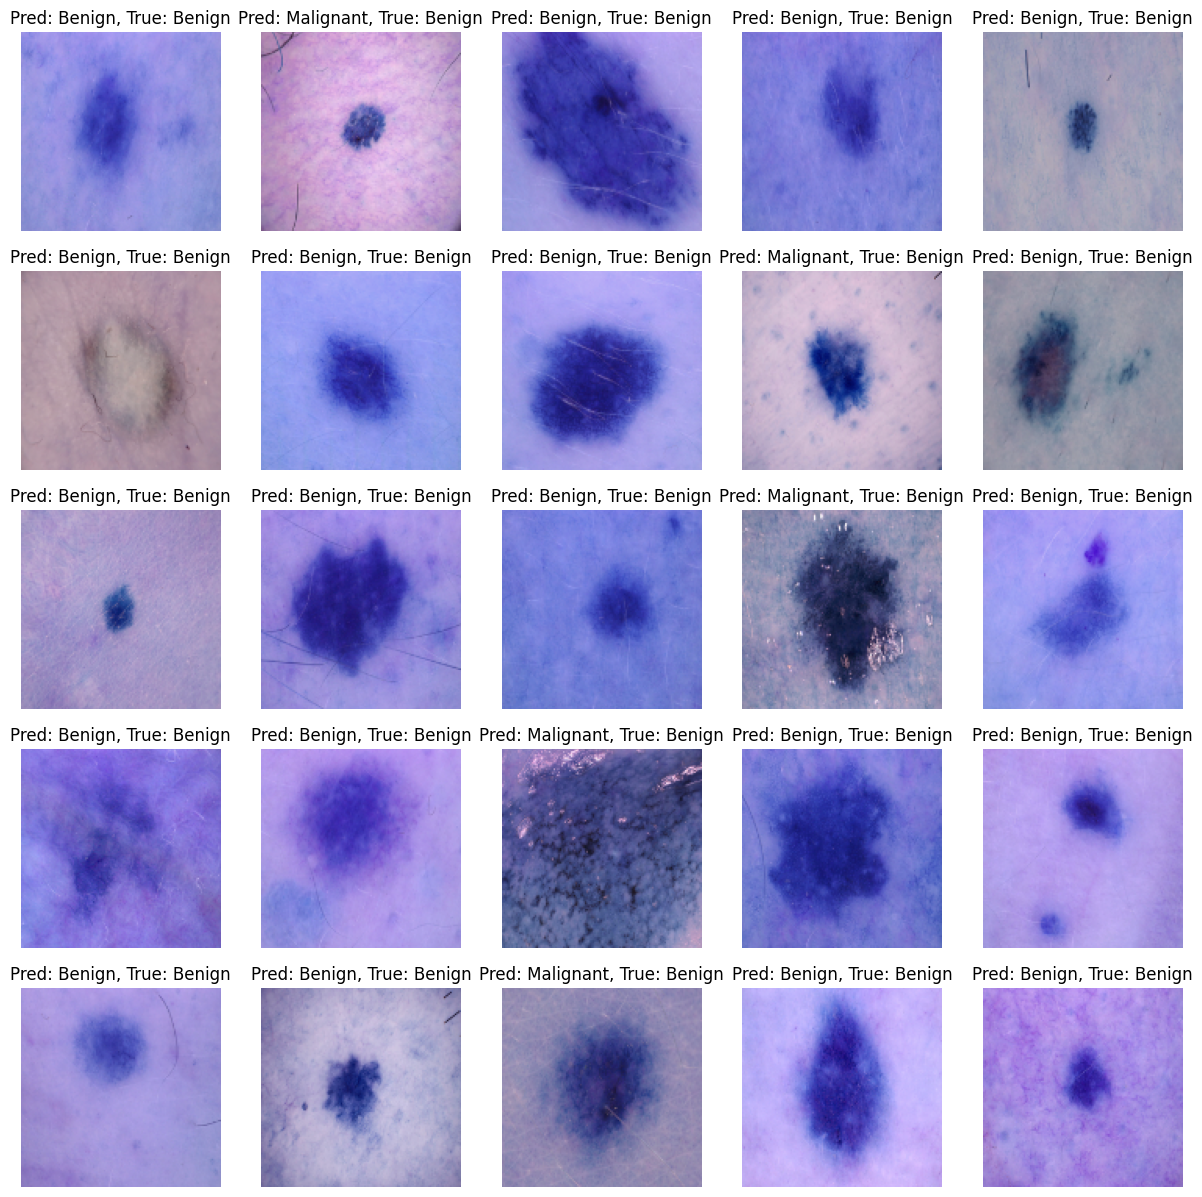

In [ ]:
from tensorflow.keras.applications import ResNet50
# Modeli oluştur
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derle ve eğit
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Taban modeli aç ve yeniden eğit
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_phase2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_phase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_fine = model.fit(train_images, train_labels, epochs=num_epochs // 2, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping_phase2, reduce_lr_phase2])

# Modeli değerlendirmek
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"ResNet50 Test Accuracy: {test_accuracy}")

# Grafikler
plot_training_history(history, "ResNet50 Initial Training")
plot_training_history(history_fine, "ResNet50 Fine-Tuning Training")

# Tahminlerin görselleştirilmesi (test verilerinden örnekler)
display_predictions(test_images[:25], test_labels[:25], model, class_names)


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3, Xception, DenseNet121, NASNetMobile, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# Hiperparametreler
image_size = 128
num_channels = 3
batch_size = 32
initial_lr = 1e-4
num_epochs = 30
dropout_rate = 0.5
num_classes = 2  # Benign ve Malignant

# Dosya yolları
base_path = '/content/drive/MyDrive/2li'
folders = ['test', 'train', 'validation']

# Apply DullRazor function
def apply_dullrazor(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_scale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray_scale, cv2.MORPH_BLACKHAT, kernel)
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)
    return img, dst

# Apply histogram equalization
def apply_histogram_equalization(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img_output

# Apply gamma correction
def apply_gamma_correction(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Görsellerin yükleneceği veri yapıları
data = {'test': [], 'train': [], 'validation': []}
labels = {'test': [], 'train': [], 'validation': []}

# Görselleri yükle, ön işlem uygula ve etiketle
for folder in folders:
    benign_path = os.path.join(base_path, folder, 'benign')
    malignant_path = os.path.join(base_path, folder, 'malignant')

    for img_name in os.listdir(benign_path):
        img_path = os.path.join(benign_path, img_name)
        original, processed = apply_dullrazor(img_path)
        equalized = apply_histogram_equalization(processed)
        gamma_corrected = apply_gamma_correction(equalized, gamma=1.2)
        img = cv2.resize(gamma_corrected, (image_size, image_size))
        data[folder].append(img)
        labels[folder].append(0)  # Benign etiketi

    for img_name in os.listdir(malignant_path):
        img_path = os.path.join(malignant_path, img_name)
        original, processed = apply_dullrazor(img_path)
        equalized = apply_histogram_equalization(processed)
        gamma_corrected = apply_gamma_correction(equalized, gamma=1.2)
        img = cv2.resize(gamma_corrected, (image_size, image_size))
        data[folder].append(img)
        labels[folder].append(1)  # Malignant etiketi

# Verileri numpy array'e çevir
for key in data.keys():
    data[key] = np.array(data[key])
    labels[key] = np.array(labels[key])

# Normalize et
for key in data.keys():
    data[key] = data[key] / 255.0

# Verileri train ve test olarak ayır
train_images, train_labels = data['train'], labels['train']
test_images, test_labels = data['test'], labels['test']
val_images, val_labels = data['validation'], labels['validation']

# Modeli oluştur
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derle ve eğit
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Taban modeli aç ve yeniden eğit
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_phase2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_phase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_fine = model.fit(train_images, train_labels, epochs=num_epochs // 2, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping_phase2, reduce_lr_phase2])

# Modeli değerlendirmek
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"ResNet50 Test Accuracy: {test_accuracy}")

# Eğitim ve doğrulama süreçlerinin accuracy ve loss grafiklerini çiz
def plot_training_history(history, title="Training and Validation Metrics"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(title)
    plt.show()

# Grafikler
plot_training_history(history, "ResNet50 Initial Training")
plot_training_history(history_fine, "ResNet50 Fine-Tuning Training")

# Tahminlerin görselleştirilmesi (test verilerinden örnekler)
def display_predictions(images, labels, model, class_names):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Pred: {class_names[predicted_labels[i]]}, True: {class_names[labels[i]]}")
        plt.axis('off')
    plt.show()

# Sınıf isimleri
class_names = ['Benign', 'Malignant']

display_predictions(test_images[:25], test_labels[:25], model, class_names)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from tensorflow.keras.applications import ResNet50

# Modeli oluştur
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derle ve eğit
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Taban modeli aç ve yeniden eğit
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_phase2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_phase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_fine = model.fit(train_images, train_labels, epochs=num_epochs // 2, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping_phase2, reduce_lr_phase2])

# Modeli değerlendirmek
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"ResNet50 Test Accuracy: {test_accuracy}")

# Grafikler
plot_training_history(history, "ResNet50 Initial Training")
plot_training_history(history_fine, "ResNet50 Fine-Tuning Training")

# Tahminlerin görselleştirilmesi (test verilerinden örnekler)
display_predictions(test_images[:25], test_labels[:25], model, class_names)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Modeli oluştur
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derle ve eğit
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Taban modeli aç ve yeniden eğit
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_phase2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_phase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_fine = model.fit(train_images, train_labels, epochs=num_epochs // 2, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping_phase2, reduce_lr_phase2])

# Modeli değerlendirmek
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"InceptionV3 Test Accuracy: {test_accuracy}")

# Grafikler
plot_training_history(history, "InceptionV3 Initial Training")
plot_training_history(history_fine, "InceptionV3 Fine-Tuning Training")

# Tahminlerin görselleştirilmesi (test verilerinden örnekler)
display_predictions(test_images[:25], test_labels[:25], model, class_names)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from tensorflow.keras.applications import Xception

# Modeli oluştur
base_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derle ve eğit
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Taban modeli aç ve yeniden eğit
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_phase2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_phase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_fine = model.fit(train_images, train_labels, epochs=num_epochs // 2, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping_phase2, reduce_lr_phase2])

# Modeli değerlendirmek
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Xception Test Accuracy: {test_accuracy}")

# Grafikler
plot_training_history(history, "Xception Initial Training")
plot_training_history(history_fine, "Xception Fine-Tuning Training")

# Tahminlerin görselleştirilmesi (test verilerinden örnekler)
display_predictions(test_images[:25], test_labels[:25], model, class_names)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Modeli oluştur
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derle ve eğit
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Taban modeli aç ve yeniden eğit
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_phase2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_phase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_fine = model.fit(train_images, train_labels, epochs=num_epochs // 2, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping_phase2, reduce_lr_phase2])

# Modeli değerlendirmek
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"DenseNet121 Test Accuracy: {test_accuracy}")

# Grafikler
plot_training_history(history, "DenseNet121 Initial Training")
plot_training_history(history_fine, "DenseNet121 Fine-Tuning Training")

# Tahminlerin görselleştirilmesi (test verilerinden örnekler)
display_predictions(test_images[:25], test_labels[:25], model, class_names)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from tensorflow.keras.applications import NASNetMobile

# Modeli oluştur
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derle ve eğit
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Taban modeli aç ve yeniden eğit
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_phase2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_phase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_fine = model.fit(train_images, train_labels, epochs=num_epochs // 2, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping_phase2, reduce_lr_phase2])

# Modeli değerlendirmek
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"NASNetMobile Test Accuracy: {test_accuracy}")

# Grafikler
plot_training_history(history, "NASNetMobile Initial Training")
plot_training_history(history_fine, "NASNetMobile Fine-Tuning Training")

# Tahminlerin görselleştirilmesi (test verilerinden örnekler)
display_predictions(test_images[:25], test_labels[:25], model, class_names)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Modeli oluştur
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, num_channels))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derle ve eğit
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping, reduce_lr])

# Taban modeli aç ve yeniden eğit
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_phase2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_phase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_fine = model.fit(train_images, train_labels, epochs=num_epochs // 2, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[early_stopping_phase2, reduce_lr_phase2])

# Modeli değerlendirmek
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"MobileNetV2 Test Accuracy: {test_accuracy}")

# Grafikler
plot_training_history(history, "MobileNetV2 Initial Training")
plot_training_history(history_fine, "MobileNetV2 Fine-Tuning Training")

# Tahminlerin görselleştirilmesi (test verilerinden örnekler)
display_predictions(test_images[:25], test_labels[:25], model, class_names)
